In [ ]:
# # # Colab에 Mecab 설치
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 6.05 MiB/s, done.
Resolving deltas: 100% (46/46), done.
bash: install_mecab-ko_on_colab190912.sh: No such file or directory


In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 51.3 MB/s 


In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
text_data = pd.read_csv("/content/gdrive/MyDrive/와이빅타/신입기수플젝/한국어_단발성_대화_데이터셋.csv", usecols=[0,1])
text_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,걱정
1,그냥 내 느낌일뿐겠지?,걱정
2,아직너무초기라서 그런거죠?,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정
...,...,...
43666,NaN,NaN
43667,NaN,NaN
43668,NaN,NaN
43669,NaN,NaN


# 결측치, 중복값 삭제

In [ ]:
text_data.isnull().any()

Sentence    True
Emotion     True
dtype: bool

In [ ]:
text_data =text_data.dropna(axis=0) # 결측치 삭제

In [ ]:
text_data['Sentence'].nunique(), text_data['Emotion'].nunique() # Sentece 열에서 중복 확인

(41534, 5)

In [ ]:
text_data = text_data.drop_duplicates(subset=['Sentence']) # Sentece 열에서 중복 제거
print('총 텍스트 샘플 수 :', len(text_data))

총 텍스트 샘플 수 : 41534


In [ ]:
text_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,걱정
1,그냥 내 느낌일뿐겠지?,걱정
2,아직너무초기라서 그런거죠?,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정
...,...,...
41639,너무 힘들어요…,슬픔
41640,"저는 원래 자존감계속되는 취업 실패에 , 그것에 대한 부모님의 실망과 눈치를 정말 ...",슬픔
41641,아버지 술주정+어머니랑 떨어짐나혼자 아버지 술주정 감당 공부도 못 함.포기해야할까요...,슬픔
41642,너 그거알아? 나만 느끼는거인지 모르겠는데 너 진짜 예뻐 그리고 멋있어,행복


# 구두점 제거

In [ ]:
import re

# 데이터 전처리: 구두점 제거
def data_preprocessing(text):
    text = re.sub(r'[^\w\s]','',text)
    return text

cnt=0
for i in text_data['Sentence']:
    # print(i)
    text_data['Sentence'][cnt] = re.sub(r'[^\w\s]','',i)
    cnt+=1
text_data[:10]

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,걱정
1,그냥 내 느낌일뿐겠지,걱정
2,아직너무초기라서 그런거죠,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정
5,남자친구가 떠날까봐요,걱정
6,이거 했는데 허리가 아플수도 있나요,걱정
7,내가불안해서꾸는걸까,걱정
8,일주일도 안 남았당ㅠㅠ,걱정
9,약은 최대한 안먹으려고 하는데좋은 음시있나요0,걱정


In [ ]:
text_data['Sentence'] = text_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
text_data[:5]

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,걱정
1,그냥 내 느낌일뿐겠지,걱정
2,아직너무초기라서 그런거죠,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정


# Emotion 인코딩


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(text_data.Emotion)
Emotion_encoded = label_encoder.transform(text_data.Emotion)

In [ ]:
text_data.Emotion = Emotion_encoded
text_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,0
1,그냥 내 느낌일뿐겠지,0
2,아직너무초기라서 그런거죠,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
41639,너무 힘들어요,2
41640,저는 원래 자존감계속되는 취업 실패에 그것에 대한 부모님의 실망과 눈치를 정말 많...,2
41641,아버지 술주정어머니랑 떨어짐나혼자 아버지 술주정 감당 공부도 못 함포기해야할까요버텨...,2
41642,너 그거알아 나만 느끼는거인지 모르겠는데 너 진짜 예뻐 그리고 멋있어,4


In [ ]:
print(label_encoder.classes_, "=>", label_encoder.transform(label_encoder.classes_))

['걱정' '분노' '슬픔' '평온' '행복'] => [0 1 2 3 4]


# 훈련 데이터와 테스트 데이터 분리

In [ ]:
train_data, test_data = train_test_split(text_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 31150
테스트용 리뷰의 개수 : 10384


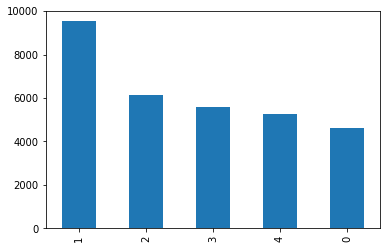

In [ ]:
train_data['Emotion'].value_counts().plot(kind = 'bar')

# 토큰화

In [ ]:
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '나', '사람', '주', '아니', '등', '같', '우리', '때', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '알', '그러나', '받', '일', '그런', '또', '사회', '많', '그리고', '중', '따르', '만들', '지금', '고', '다', '거', '면'] # 불용어

In [ ]:
train_data['tokenized'] = train_data['Sentence'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
test_data['tokenized'] = test_data['Sentence'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 단어와 길이 분포 확인

In [ ]:
worry_words = np.hstack(train_data[train_data.Emotion == 0]['tokenized'].values)
negative_words = np.hstack(train_data[train_data.Emotion == 1]['tokenized'].values)
sad_words = np.hstack(train_data[train_data.Emotion == 2]['tokenized'].values)
calmn_words = np.hstack(train_data[train_data.Emotion == 3]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.Emotion == 4]['tokenized'].values)

In [ ]:
worry_word_count = Counter(worry_words)
print(worry_word_count.most_common(20))

[('는데', 465), ('안', 422), ('겠', 372), ('어', 333), ('네요', 311), ('없', 304), ('아', 303), ('너무', 262), ('기', 246), ('만', 242), ('해', 240), ('해야', 229), ('좋', 225), ('할', 222), ('저', 220), ('제', 216), ('로', 209), ('으로', 209), ('내', 207), ('싶', 190)]


In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 755), ('아', 708), ('냐', 694), ('없', 666), ('만', 584), ('어', 574), ('으로', 508), ('겠', 498), ('로', 489), ('진짜', 474), ('라', 472), ('니', 464), ('해', 460), ('나라', 427), ('는데', 410), ('야', 393), ('ㅋㅋ', 392), ('기', 381), ('ㅋㅋㅋ', 373), ('에서', 372)]


In [ ]:
sad_word_count = Counter(sad_words)
print(sad_word_count.most_common(20))

[('는데', 796), ('너무', 795), ('어', 712), ('내', 702), ('안', 677), ('싶', 646), ('없', 605), ('겠', 604), ('아', 598), ('네요', 596), ('해', 565), ('힘들', 517), ('좋', 516), ('만', 508), ('어요', 462), ('ㅠㅠ', 438), ('었', 372), ('했', 353), ('않', 350), ('기', 349)]


In [ ]:
calmn_word_count = Counter(calmn_words)
print(calmn_word_count.most_common(20))

[('안', 406), ('아', 403), ('겠', 399), ('좋', 387), ('어', 380), ('없', 374), ('만', 362), ('는데', 357), ('내', 332), ('해', 300), ('너무', 299), ('으로', 298), ('했', 298), ('로', 287), ('할', 268), ('었', 266), ('에서', 251), ('ㅋㅋ', 239), ('싶', 236), ('네요', 231)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('ㅋㅋㅋ', 537), ('좋', 517), ('ㅋㅋ', 411), ('합니다', 393), ('감사', 381), ('잘', 373), ('너무', 358), ('해', 358), ('네요', 345), ('아', 303), ('님', 302), ('습니다', 299), ('진짜', 287), ('어', 268), ('는데', 260), ('으로', 260), ('었', 241), ('했', 240), ('정말', 237), ('시', 233)]


부정 리뷰의 평균 길이 : 8.651328580686974
긍정 리뷰의 평균 길이 : 8.851264826283195


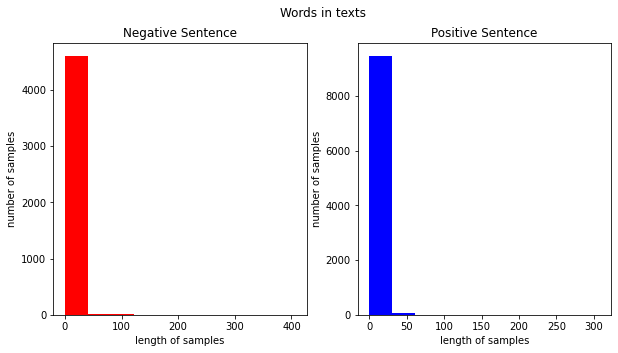

In [ ]:
fig,(ax2,ax1) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['Emotion']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Negative Sentence')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['Emotion']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('Positive Sentence')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['Emotion'].values
X_test= test_data['tokenized'].values
y_test = test_data['Emotion'].values

# 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 23172
등장 빈도가 1번 이하인 희귀 단어의 수: 11130
단어 집합에서 희귀 단어의 비율: 48.03210771620922
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9488809729929177


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12044


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[173, 3522, 6807, 180, 18, 82, 2159, 221], [6808, 234, 243, 6808, 8, 42, 1168, 38, 72, 1966], [396, 131, 12043, 1319, 2160, 5, 75, 1031, 1516, 1363, 764, 53, 764, 271, 5641, 136, 144, 243, 222, 17, 122, 1675, 1056]]


In [ ]:
print(X_test[:3])

[[10, 2, 120, 97, 3440, 227, 49, 813, 73, 41], [106, 318, 5240, 44, 10, 6, 26], [1410, 316, 835, 1345, 225, 262]]


# 패딩

리뷰의 최대 길이 : 402
리뷰의 평균 길이 : 8.690947030497592


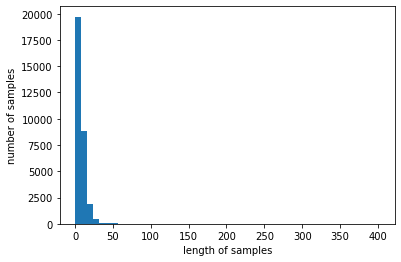

In [ ]:
print('리뷰의 최대 길이 :',max(len(sentence) for sentence in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sentence) for sentence in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.82022471910112


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# GRU로 감성 분류

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
# model.add(Dense(hidden_units, activation='sigmoid'))
# model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 100)         1204400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_40 (Dense)            (None, 128)               16512     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 5)                 645       
                                                                 
Total params: 1,338,805
Trainable params: 1,338,805
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
388/390 [============================>.] - ETA: 0s - loss: 1.3438 - acc: 0.4435
Epoch 1: val_acc improved from -inf to 0.52841, saving model to best_model.h5
390/390 [==============================] - 13s 28ms/step - loss: 1.3432 - acc: 0.4441 - val_loss: 1.1985 - val_acc: 0.5284
Epoch 2/15
389/390 [============================>.] - ETA: 0s - loss: 1.0576 - acc: 0.5896
Epoch 2: val_acc improved from 0.52841 to 0.56469, saving model to best_model.h5
390/390 [==============================] - 10s 25ms/step - loss: 1.0572 - acc: 0.5898 - val_loss: 1.1382 - val_acc: 0.5647
Epoch 3/15
390/390 [==============================] - ETA: 0s - loss: 0.9005 - acc: 0.6655
Epoch 3: val_acc improved from 0.56469 to 0.56661, saving model to best_model.h5
390/390 [==============================] - 9s 24ms/step - loss: 0.9005 - acc: 0.6655 - val_loss: 1.1581 - val_acc: 0.5666
Epoch 4/15
388/390 [============================>.] - ETA: 0s - loss: 0.7661 - acc: 0.7273
Epoch 4: val_acc did not imp

In [ ]:
loaded_model = load_model('best_model.h5')
loaded_model.save('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

325/325 [==============================] - 3s 9ms/step - loss: 1.1715 - acc: 0.5595

 테스트 정확도: 0.5595


In [ ]:
# from google.colab import files
# files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# model = load_model('/content/gdrive/MyDrive/와이빅타/신입기수플젝/best_model.h5')

# 감성 예측

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('상수야 개패기전에 그만개겨라')

99.03% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('무슨 똑같은말만 40분을 하네 ;;;;')

99.68% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('귀요미 끝판왕')

90.13% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('형 나 형 쇼미하는거 보고왔서 형 랩 엄청 잘하네!! 열심히해!!')

99.64% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('상수야 현피 함 뜨자 연락해라')

96.99% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('방송 접자 그냥.')

73.38% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('상수야 경찰 떳는데 혹시 또 테이저건 맞았냐?')

98.37% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('진짜 요즘 텐션 지렸다ㅋㅋ')

97.71% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('상수야 나 5살인데 말 놓을게')

93.41% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('형님  여자친구와 오늘 헤어젔습니다   울어야하는데  형님 방송보면서 실실 쪼개고 있는  저 자신이 ㅄ같지만  형님떄문에 힘이납니다  맨날 방송해주세요  그래야 다시일어설수있을꺼같습니다')

98.94% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('상수형 진짜 저랑 생방으로 딱 한번만 현피떠주시면 안될까요?')

56.75% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('나잇값 못하이 맞았겠지 상수야 ㅋㅋㅋㅋㅋ')

64.34% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('나랑 현피 뜨실 니어디산 아 대구에 산다 탈모 병신 새끼야')

99.93% 확률로 부정 리뷰입니다.
